The object of this section is to calculate the theoretical maximum yields for chosen product for suitable carbon sources. Therefore, we should first see which different carbon sources are avialable:

In [28]:
# Libraries to be imported:
from cobra.io import read_sbml_model, write_sbml_model # To read the model and save new newly generated model
from cobra import Reaction, Metabolite # To creat new reactions and metabolites
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
# Define the model based on the dataset in iY0844 with the added reactions:
iY0844_model = read_sbml_model("data/iYO844_modified.xml")

In [30]:
# Simulate base medium in the model:
iY0844_model.medium

{'EX_fe3_e': 999999.0,
 'EX_glc__D_e': 1.7,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

From this base medium we can see, that 1.7 glucose is used. Therefore, this will be the boundary for the comming analysis. 

First, we find all carbon exchange reactions in our model, and from this we establish a baseline to use for later reference:

In [31]:
# Create empty lists:
carbon = []
carbon_names = []

# Create a loop where we find all reactions that contains carbon:
for reaction in iY0844_model.exchanges:
    for metabolite in reaction.reactants:
        if "C" in metabolite.elements:
            carbon.append(reaction.id)
            carbon_names.append(reaction.name) 
            
# Make temporary changes in the model:
with iY0844_model:
    max_base_growth = iY0844_model.slim_optimize()
    iY0844_model.objective = iY0844_model.reactions.ALDH1_CYP71AV1
    max_base_production = iY0844_model.slim_optimize()


Now, we create a loop going through every carbon source in our model, and see how well it produces dihydroartemisinic acid. The ID's for the different carbon sources are found in BIGG by filtering for B. subtilis. 

In [32]:
# Define lists we will be using for growth and production:
# Define media:
max_growth = []
max_production = []
medium=iY0844_model.medium


In [33]:
# Create loop for temporary changes in our model:
with iY0844_model:
    for reaction in carbon:
        medium['EX_glc__D_e'] = 0 # glucose in the medium
        medium[reaction]=1.7 # same boundary as glucose
        iY0844_model.medium = medium
        with iY0844_model:
            max_growth.append(iY0844_model.slim_optimize(error_value=0.))
            iY0844_model.objective = iY0844_model.reactions.ALDH1_CYP71AV1 # production of dihydroartemisinic acid
            max_production.append(iY0844_model.slim_optimize(error_value=0.))  # Determining max production
        medium[reaction]=0        


In [34]:
# Now, we collect all of the data in a dataframe:
production = {'Carbon': carbon_names,
             'Growth': max_growth,
             'Production': max_production}
df = pd.DataFrame(production, columns = ['Carbon', 'Growth', 'Production'])
print(df)

                              Carbon        Growth    Production
0              Ethanolamine exchange -1.253798e-15 -2.641745e-33
1            Deoxy D Ribose exchange  8.771332e-02  2.711429e-01
2                  Cytosine exchange  0.000000e+00  0.000000e+00
3     5-Methylthio-D-ribose exchange  0.000000e+00  0.000000e+00
4                      DTMP exchange  1.020601e-01  2.833333e-01
..                               ...           ...           ...
191                  3'-AMP exchange  1.539067e-01  4.702857e-01
192                  3'-cmp exchange  1.029840e-01  3.148571e-01
193                  3'-GMP exchange  1.427084e-01  4.362857e-01
194   3 Phospho D glycerate exchange  3.271154e-02  1.011429e-01
195  D-fructose 6-phosphate exchange  1.226962e-01  3.780000e-01

[196 rows x 3 columns]


From this tabel we can see the growth and production on different carbon sources. We are only interested in carbon sources that result in growth above zero. Therefore, we remove all carbon sources where growth is equal to zero. 

In [35]:
# Create dataframe:
df= df[df['Growth'] != 0]
print(df)

                              Carbon        Growth    Production
0              Ethanolamine exchange -1.253798e-15 -2.641745e-33
1            Deoxy D Ribose exchange  8.771332e-02  2.711429e-01
4                      DTMP exchange  1.020601e-01  2.833333e-01
5     6 Phospho D gluconate exchange  1.116600e-01  3.440000e-01
7          Alpha L Arabinan exchange  3.402663e-01  1.048286e+00
..                               ...           ...           ...
191                  3'-AMP exchange  1.539067e-01  4.702857e-01
192                  3'-cmp exchange  1.029840e-01  3.148571e-01
193                  3'-GMP exchange  1.427084e-01  4.362857e-01
194   3 Phospho D glycerate exchange  3.271154e-02  1.011429e-01
195  D-fructose 6-phosphate exchange  1.226962e-01  3.780000e-01

[117 rows x 3 columns]


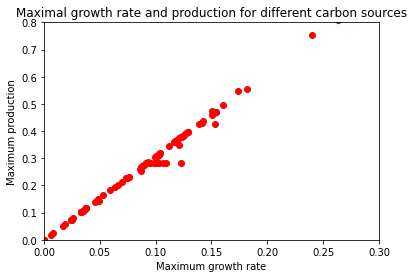

In [36]:
# We create a scatterplot of the production over growth to view the distribution
plt.scatter(df.get('Growth'), df.get('Production'),c='red')
plt.xlabel('Maximum growth rate')
plt.ylabel('Maximum production')
plt.xlim(0, 0.3)
plt.ylim(0, 0.8)
plt.title('Maximal growth rate and production for different carbon sources')
plt.savefig("figures/carbon_sources")
plt.show()

In [40]:
# To compare, we look at the carbon soruces resulting in the top 20 highest growth
df.sort_values(by='Growth', ascending=False).head(20)

,Carbon,Growth,Production
158,Maltotriose exchange,0.420673,1.296000
82,Raffinose exchange,0.419096,1.291143
7,Alpha L Arabinan exchange,0.340266,1.048286
80,Cellobiose exchange,0.269319,0.829714
157,Maltose exchange,0.269319,0.829714
127,Trehalose exchange,0.269319,0.829714
109,Sucrose exchange,0.269319,0.829714
19,Dextrin exchange,0.267743,0.824857
176,Palatinose exchange,0.267743,0.824857
106,Starch exchange,0.267743,0.824857


As we can see from this table, maltotiose, maltose and sucrose looks promising, resulting in the 5th and 7th highest growth, respectively, while they also result in high production. We choose to continue investigation on these carbon sources, as they are the most readily available carbon sources, and will therefore not be too expensive to use in a medium.

Now we look at the maximum growth and production obtained from glucose, which we will then compare with the growth and production obtained from the alternative carbon sources:

In [37]:
# Examining the model with glucose as carbon source:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 1.7
iY0844_model.medium = medium
write_sbml_model(iY0844_model, "data/iYO844_modified_glucose.xml") # create new file with modified model on glucose
iY0844_model_glucose = read_sbml_model('data/iYO844_modified_glucose.xml')
iY0844_model_glucose.medium 

{'EX_fe3_e': 999999.0,
 'EX_glc__D_e': 1.7,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

In [38]:
# Claculate the max. theoretical yield for production on glucose
with iY0844_model_glucose:
    iY0844_model_glucose.objective = iY0844_model_glucose.reactions.ALDH1_CYP71AV1
    DHAA_production_1 = iY0844_model_glucose.optimize().objective_value
    max_yield_glucose = DHAA_production_1 / (-1*iY0844_model_glucose.reactions.EX_glc__D_e.flux)
    print("Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]:", DHAA_production_1)
    print("Theoretical max. yield [mmol-dhart_acid / mmol-glucose]:", max_yield_glucose) 

Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]: 0.3634285714285713
Theoretical max. yield [mmol-dhart_acid / mmol-glucose]: 0.21378151260504197


In [39]:
# Now we convert to Cmol/Cmol
CV_dhAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_glc = 6 # Cmol/mol conversion factor for glucose

dhAA_glc_production_cmol = (max_yield_glucose*CV_dhAA)/(1*CV_glc)
print('Maximum theoretical yield cmol/cmol=', dhAA_glc_production_cmol, 'cmol-AA/cmol-glc')

Maximum theoretical yield cmol/cmol= 0.5344537815126049 cmol-AA/cmol-glc


In [41]:
# Now we investigate maltotriose - we look for the ID of maltotriose:
for reaction in iY0844_model.reactions.query('Maltotriose exchange', 'name'):
    print(reaction.id)

EX_malttr_e


In [42]:
# Changing the carbon source to maltotriose rather than glucose in our medium:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 0
medium["EX_malttr_e"]= 1.7 # set the same boundary as for base medium w. glucose
iY0844_model.medium = medium
write_sbml_model(iY0844_model, "data/iYO844_modified_maltotriose.xml") #create new file with modified model on maltotriose
iY0844_model_maltotriose = read_sbml_model('data/iYO844_modified_maltotriose.xml')
iY0844_model_maltotriose.medium # see that glucose has been deleted and maltotriose added

{'EX_fe3_e': 999999.0,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_malttr_e': 1.7,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

In [43]:
# Claculate the max. theoretical yield for production on maltotriose
with iY0844_model_maltotriose:
    iY0844_model_maltotriose.objective = iY0844_model_maltotriose.reactions.ALDH1_CYP71AV1
    DHAA_production_2 = iY0844_model_maltotriose.optimize().objective_value
    max_yield_maltotriose = DHAA_production_2 / (-1*iY0844_model_maltotriose.reactions.EX_malttr_e.flux)
    print("Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]:", DHAA_production_2)
    print("Theoretical max. yield [mmol-dhart_acid / mmol-maltotriose]:", max_yield_maltotriose)

Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]: 1.2960000000000031
Theoretical max. yield [mmol-dhart_acid / mmol-maltotriose]: 0.7623529411764725


In [44]:
# Now we convert to Cmol/Cmol
CV_dhAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_malttr = 18 # Cmol/mol conversion factor for maltotriose

dhAA_malttr_production_cmol = (max_yield_maltotriose*CV_dhAA)/(1*CV_malttr)
print('Maximum theoretical yield cmol/cmol=', dhAA_malttr_production_cmol, 'cmol-AA/cmol-glc')

Maximum theoretical yield cmol/cmol= 0.6352941176470605 cmol-AA/cmol-glc


In [45]:
# Second we investigate maltose - we look for the ID of maltose:
for reaction in iY0844_model.reactions.query('Maltose exchange', 'name'):
    print(reaction.id)

EX_malt_e


In [46]:
# Changing the carbon source to maltose in our medium:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 0
medium["EX_malttr_e"]= 0
medium["EX_malt_e"]= 1.7 # set the same boundary as for base medium w. glucose
iY0844_model.medium = medium
write_sbml_model(iY0844_model, "data/iYO844_modified_maltose.xml") # create new file with modified model on maltose
iY0844_model_maltose = read_sbml_model('data/iYO844_modified_maltose.xml')
iY0844_model_maltose.medium # see that glucose has been deleted and maltose added

{'EX_fe3_e': 999999.0,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_malt_e': 1.7,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

In [47]:
# Claculate the max. theoretical yield for production on maltose
with iY0844_model_maltose:
    iY0844_model_maltose.objective = iY0844_model_maltose.reactions.ALDH1_CYP71AV1
    DHAA_production_3 = iY0844_model_maltose.optimize().objective_value
    max_yield_maltose = DHAA_production_3 / (-1*iY0844_model_maltose.reactions.EX_malt_e.flux)
    print("Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]:", DHAA_production_3)
    print("Theoretical max. yield [mmol-dhart_acid / mmol-maltose]:", max_yield_maltose)

Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]: 0.8297142857142857
Theoretical max. yield [mmol-dhart_acid / mmol-maltose]: 0.4880672268907563


In [48]:
# Now we convert to Cmol/Cmol
CV_dhAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_malt = 12 # Cmol/mol conversion factor for maltose

dhAA_malt_production_cmol = (max_yield_maltose*CV_dhAA)/(1*CV_malt)
print('Maximum theoretical yield cmol/cmol=', dhAA_malt_production_cmol, 'cmol-AA/cmol-glc')

Maximum theoretical yield cmol/cmol= 0.6100840336134454 cmol-AA/cmol-glc


In [49]:
# Lastly, we investigate sucrose - we look for the ID of sucrose:
for reaction in iY0844_model.reactions.query('Sucrose exchange', 'name'):
    print(reaction.id)

EX_sucr_e


In [50]:
# Changing the carbon source to sucrose in our medium:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 0
medium["EX_malttr_e"]= 0 
medium["EX_malt_e"]= 0
medium["EX_sucr_e"]= 1.7 # set the same boundary as for base medium w. glucose
iY0844_model.medium = medium
write_sbml_model(iY0844_model, "data/iYO844_modified_sucrose.xml") # create new file with modified model on sucrose
iY0844_model_sucrose = read_sbml_model('data/iYO844_modified_sucrose.xml')
iY0844_model_sucrose.medium # see that glucose has been deleted and sucrose added

{'EX_fe3_e': 999999.0,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_sucr_e': 1.7,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

In [51]:
# Claculate the max. theoretical yield for production on sucrose
with iY0844_model_sucrose:
    iY0844_model_sucrose.objective = iY0844_model_sucrose.reactions.ALDH1_CYP71AV1
    DHAA_production_4 = iY0844_model_sucrose.optimize().objective_value
    max_yield_sucrose = DHAA_production_4 / (-1*iY0844_model_sucrose.reactions.EX_sucr_e.flux)
    print("Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]:", DHAA_production_4)
    print("Theoretical max. yield [mmol-dhart_acid / mmol-sucrose]:", max_yield_sucrose)

Max. dihydroartemisinic acid production [mmol gDW^-1 h^-1]: 0.8297142857142857
Theoretical max. yield [mmol-dhart_acid / mmol-sucrose]: 0.4880672268907563


In [52]:
# Now we convert to Cmol/Cmol
CV_dhAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_sucr = 12 # Cmol/mol conversion factor for sucrose

dhAA_sucr_production_cmol = (max_yield_sucrose*CV_dhAA)/(1*CV_sucr)
print('Maximum theoretical yield cmol/cmol=', dhAA_sucr_production_cmol, 'cmol-AA/cmol-glc')

Maximum theoretical yield cmol/cmol= 0.6100840336134454 cmol-AA/cmol-glc


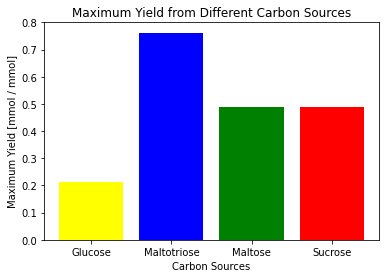

In [53]:
# Generate bar plot to visualize mmol/mmol

# Write values
yield_glucose = max_yield_glucose
yield_maltotriose = max_yield_maltotriose
yield_maltose = max_yield_maltose
yield_sucrose = max_yield_sucrose

# Carbon sources
carbon_sources = ['Glucose', 'Maltotriose', 'Maltose', 'Sucrose']

# Maximum yields
max_yields = [yield_glucose, yield_maltotriose, yield_maltose, yield_sucrose]

# Plotting
plt.bar(carbon_sources, max_yields, color=['yellow', 'blue', 'green', 'red'])
plt.xlabel('Carbon Sources')
plt.ylabel('Maximum Yield [mmol / mmol]')
plt.title('Maximum Yield from Different Carbon Sources')
plt.show()


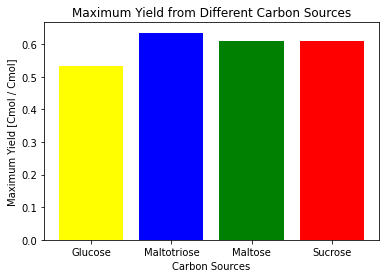

In [54]:
# Generate bar plot to visualize Cmol/Cmol

# Write values
yield_glucose_cmol = dhAA_glc_production_cmol
yield_maltotriose_cmol = dhAA_malttr_production_cmol
yield_maltose_cmol = dhAA_malt_production_cmol
yield_sucrose_cmol = dhAA_sucr_production_cmol

# Carbon sources
carbon_sources_cmol = ['Glucose', 'Maltotriose', 'Maltose', 'Sucrose']

# Maximum yields
max_yields_cmol = [yield_glucose_cmol, yield_maltotriose_cmol, yield_maltose_cmol, yield_sucrose_cmol]

# Plotting
plt.bar(carbon_sources_cmol, max_yields_cmol, color=['yellow', 'blue', 'green', 'red'])
plt.xlabel('Carbon Sources')
plt.ylabel('Maximum Yield [Cmol / Cmol]')
plt.title('Maximum Yield from Different Carbon Sources')
plt.show()


CONCLUSION

From this analysis we can conclude, that all three alternative carbo sources result in a higher maximum theoretical yield of dihydroartemisinic acid than glucose. Maltotriose result in the highest maximum yield of approx. 0.76 mmol dihydroartemisinic acid pr. mmol maltotriose, whereas maltose and sucrose result in the same maximum theoretical yield of 0.48 mmol dihydroartemisinic acid pr. mmol maltose and sucrose. 

However, when we convert to Cmol/Cmol, we can see that maltose and sucrose produces almost the same max. theoretical yield of dihydroartemisinic acid as maltotriose, namely 0.61 Cmol/Cmol and 0.63 Cmol/Cmol, respectively. This is compared to the maximum theroretical yield obtained from glucose of 0.53 Cmol/Cmol. When making this comparison, it can be concluded that maltotriose does not produce a significant higher amount of dihydroartemisinic acid compared to maltose and sucrose. Furthermore, the 3 alternative carbon sources does not produce a significantly higher maximum theoretical yield than glucose. as glucose is the cheapest carbon source to use in fermentation, and as it is easily and readily available, we will therefore continue with glucose as carbon source.